In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Faker/faceswap-master

/content/drive/MyDrive/Faker/faceswap-master


In [3]:
import os
import shutil

# 설정 파일을 저장할 경로 생성
config_dir = "/usr/local/lib/python3.10/dist-packages/config/"
os.makedirs(config_dir, exist_ok=True)

# 설정 파일을 해당 경로로 복사
source = "/content/drive/MyDrive/Faker/faceswap-master/config/.faceswap"
destination = config_dir + ".faceswap"

shutil.copy(source, destination)

print("설정 파일을 복사했습니다.")


설정 파일을 복사했습니다.


In [4]:
import os
import sys
import importlib

# 현재 디렉토리를 유지하면서 sys.path에 추가
current_path = '/content/drive/MyDrive/Faker/faceswap-master'
lib_path = os.path.join(current_path, 'lib')
if lib_path not in sys.path:
    sys.path.insert(0, lib_path)

# 동적으로 모듈 임포트
try:
    networks_simple_nets = importlib.import_module('lib.model.networks.simple_nets')
    clip = importlib.import_module('lib.model.networks.clip')
    feature_loss = importlib.import_module('lib.model.losses.feature_loss')
    loss = importlib.import_module('lib.model.losses.loss')
    perceptual_loss = importlib.import_module('lib.model.losses.perceptual_loss')
    initializers = importlib.import_module('lib.model.initializers')
    layers = importlib.import_module('lib.model.layers')
    nn_blocks = importlib.import_module('lib.model.nn_blocks')
    normalization = importlib.import_module('lib.model.normalization')
    optimizers = importlib.import_module('lib.model.optimizers')
    session = importlib.import_module('lib.model.session')
    autoclip = importlib.import_module('lib.model.autoclip')
    backup_restore = importlib.import_module('lib.model.backup_restore')

    print("Successfully imported all modules using importlib.")
except ImportError as e:
    print(f"ImportError: {e}")


Setting Faceswap backend to NVIDIA
Successfully imported all modules using importlib.


In [5]:
#!/usr/bin/env python3
""" Custom Feature Map Loss Functions for faceswap.py """
from __future__ import annotations
from dataclasses import dataclass, field
import logging
import typing as T

# Ignore linting errors from Tensorflow's thoroughly broken import system
import tensorflow as tf
from tensorflow.keras import applications as kapp  # pylint:disable=import-error
from tensorflow.keras.layers import Dropout, Conv2D, Input, Layer, Resizing  # noqa,pylint:disable=no-name-in-module,import-error
from tensorflow.keras.models import Model  # pylint:disable=no-name-in-module,import-error
import tensorflow.keras.backend as K  # pylint:disable=no-name-in-module,import-error

import numpy as np

from lib.model.networks import AlexNet, SqueezeNet
from lib.utils import GetModel

if T.TYPE_CHECKING:
    from collections.abc import Callable

logger = logging.getLogger(__name__)


@dataclass
class NetInfo:
    model_id: int = 0
    model_name: str = ""
    net: Callable | None = None
    init_kwargs: dict[str, T.Any] = field(default_factory=dict)
    needs_init: bool = True
    outputs: list[Layer] = field(default_factory=list)


class _LPIPSTrunkNet():
    def __init__(self, net_name: str, eval_mode: bool, load_weights: bool) -> None:
        logger.debug("Initializing: %s (net_name '%s', eval_mode: %s, load_weights: %s)",
                     self.__class__.__name__, net_name, eval_mode, load_weights)
        self._eval_mode = eval_mode
        self._load_weights = load_weights
        self._net_name = net_name
        self._net = self._nets[net_name]
        logger.debug("Initialized: %s ", self.__class__.__name__)

    @property
    def _nets(self) -> dict[str, NetInfo]:
        """ :class:`NetInfo`: The Information about the requested net."""
        return {
            "alex": NetInfo(model_id=15,
                            model_name="alexnet_imagenet_no_top_v1.h5",
                            net=AlexNet,
                            outputs=[f"features.{idx}" for idx in (0, 3, 6, 8, 10)]),
            "squeeze": NetInfo(model_id=16,
                               model_name="squeezenet_imagenet_no_top_v1.h5",
                               net=SqueezeNet,
                               outputs=[f"features.{idx}" for idx in (0, 4, 7, 9, 10, 11, 12)]),
            "vgg16": NetInfo(model_id=17,
                             model_name="vgg16_imagenet_no_top_v1.h5",
                             net=kapp.vgg16.VGG16,
                             init_kwargs={"include_top": False, "weights": None},
                             outputs=[f"block{i + 1}_conv{2 if i < 2 else 3}" for i in range(5)])}

    @classmethod
    def _normalize_output(cls, inputs: tf.Tensor, epsilon: float = 1e-10) -> tf.Tensor:
        # norm_factor = K.sqrt(K.sum(K.square(inputs), axis=-1, keepdims=True))
        # return inputs / (norm_factor + epsilon)

        # Keras 레이어 내에서 연산하도록 수정
        def normalize_fn(x):
            norm_factor = K.sqrt(K.sum(K.square(x), axis=-1, keepdims=True))
            return x / (norm_factor + epsilon)

        # Keras Lambda 레이어로 변환
        return tf.keras.layers.Lambda(lambda x: normalize_fn(x))(inputs)


    def _process_weights(self, model: Model) -> Model:
        if self._load_weights:
            weights = GetModel(self._net.model_name, self._net.model_id).model_path
            model.load_weights(weights)

        if self._eval_mode:
            model.trainable = False
            for layer in model.layers:
                layer.trainable = False
        return model

    def __call__(self) -> Model:
        if self._net.net is None:
            raise ValueError("No net loaded")

        model = self._net.net(**self._net.init_kwargs)
        model = model if self._net_name == "vgg16" else model()
        out_layers = [self._normalize_output(model.get_layer(name).output)
                      for name in self._net.outputs]
        model = Model(inputs=model.input, outputs=out_layers)
        model = self._process_weights(model)
        return model


class _LPIPSLinearNet(_LPIPSTrunkNet):
    def __init__(self,
                 net_name: str,
                 eval_mode: bool,
                 load_weights: bool,
                 trunk_net: Model,
                 use_dropout: bool) -> None:
        logger.debug(
            "Initializing: %s (trunk_net: %s, use_dropout: %s)", self.__class__.__name__,
            trunk_net, use_dropout)
        super().__init__(net_name=net_name, eval_mode=eval_mode, load_weights=load_weights)

        self._trunk = trunk_net
        self._use_dropout = use_dropout

        logger.debug("Initialized: %s", self.__class__.__name__)

    @property
    def _nets(self) -> dict[str, NetInfo]:
        """ :class:`NetInfo`: The Information about the requested net."""
        return {
            "alex": NetInfo(model_id=18,
                            model_name="alexnet_lpips_v1.h5",),
            "squeeze": NetInfo(model_id=19,
                               model_name="squeezenet_lpips_v1.h5"),
            "vgg16": NetInfo(model_id=20,
                             model_name="vgg16_lpips_v1.h5")}

    def _linear_block(self, net_output_layer: tf.Tensor) -> tuple[tf.Tensor, tf.Tensor]:
        in_shape = K.int_shape(net_output_layer)[1:]
        input_ = Input(in_shape)
        var_x = Dropout(rate=0.5)(input_) if self._use_dropout else input_
        var_x = Conv2D(1, 1, strides=1, padding="valid", use_bias=False)(var_x)
        return input_, var_x

    def __call__(self) -> Model:
        inputs = []
        outputs = []

        for input_ in self._trunk.outputs:
            in_, out = self._linear_block(input_)
            inputs.append(in_)
            outputs.append(out)

        model = Model(inputs=inputs, outputs=outputs)
        model = self._process_weights(model)
        return model


# class LPIPSLoss():
#     def __init__(self,  # pylint:disable=too-many-arguments
#                  trunk_network: str,
#                  trunk_pretrained: bool = True,
#                  trunk_eval_mode: bool = True,
#                  linear_pretrained: bool = True,
#                  linear_eval_mode: bool = True,
#                  linear_use_dropout: bool = True,
#                  lpips: bool = True,
#                  spatial: bool = False,
#                  normalize: bool = True,
#                  ret_per_layer: bool = False) -> None:
#         logger.debug(
#             "Initializing: %s (trunk_network '%s', trunk_pretrained: %s, trunk_eval_mode: %s, "
#             "linear_pretrained: %s, linear_eval_mode: %s, linear_use_dropout: %s, lpips: %s, "
#             "spatial: %s, normalize: %s, ret_per_layer: %s)", self.__class__.__name__,
#             trunk_network, trunk_pretrained, trunk_eval_mode, linear_pretrained, linear_eval_mode,
#             linear_use_dropout, lpips, spatial, normalize, ret_per_layer)

#         self._spatial = spatial
#         self._use_lpips = lpips
#         self._normalize = normalize
#         self._ret_per_layer = ret_per_layer
#         self._shift = K.constant(np.array([-.030, -.088, -.188],
#                                           dtype="float32")[None, None, None, :])
#         self._scale = K.constant(np.array([.458, .448, .450],
#                                           dtype="float32")[None, None, None, :])

#         # Loss needs to be done as fp32. We could cast at output, but better to update the model
#         switch_mixed_precision = tf.keras.mixed_precision.global_policy().name == "mixed_float16"
#         if switch_mixed_precision:
#             logger.debug("Temporarily disabling mixed precision")
#             tf.keras.mixed_precision.set_global_policy("float32")

#         self._trunk_net = _LPIPSTrunkNet(trunk_network, trunk_eval_mode, trunk_pretrained)()
#         self._linear_net = _LPIPSLinearNet(trunk_network,
#                                            linear_eval_mode,
#                                            linear_pretrained,
#                                            self._trunk_net,
#                                            linear_use_dropout)()
#         if switch_mixed_precision:
#             logger.debug("Re-enabling mixed precision")
#             tf.keras.mixed_precision.set_global_policy("mixed_float16")
#         logger.debug("Initialized: %s", self.__class__.__name__)

#     def _process_diffs(self, inputs: list[tf.Tensor]) -> list[tf.Tensor]:
#         if self._use_lpips:
#             return self._linear_net(inputs)
#         return [K.sum(x, axis=-1) for x in inputs]

#     def _process_output(self, inputs: tf.Tensor, output_dims: tuple) -> tf.Tensor:
#         if self._spatial:
#             return Resizing(*output_dims, interpolation="bilinear")(inputs)
#         return K.mean(inputs, axis=(1, 2), keepdims=True)

#     def __call__(self, y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
#         if self._normalize:
#             y_true = (y_true * 2.0) - 1.0
#             y_pred = (y_pred * 2.0) - 1.0

#         y_true = (y_true - self._shift) / self._scale
#         y_pred = (y_pred - self._shift) / self._scale

#         net_true = self._trunk_net(y_true)
#         net_pred = self._trunk_net(y_pred)

#         diffs = [(out_true - out_pred) ** 2
#                  for out_true, out_pred in zip(net_true, net_pred)]

#         dims = K.int_shape(y_true)[1:3]
#         res = [self._process_output(diff, dims) for diff in self._process_diffs(diffs)]

#         axis = 0 if self._spatial else None
#         val = K.sum(res, axis=axis)

#         retval = (val, res) if self._ret_per_layer else val
#         return retval / 10.0   # Reduce by factor of 10 'cos this loss is STRONG

In [6]:
from tensorflow.keras.layers import Layer

class FGSMAttackLayer(Layer):
    def __init__(self, epsilon, **kwargs):
        super(FGSMAttackLayer, self).__init__(**kwargs)
        self.epsilon = epsilon

    def call(self, inputs):
        image, data_grad = inputs
        sign_data_grad = tf.sign(data_grad)
        perturbed_image = image + self.epsilon * sign_data_grad
        return tf.clip_by_value(perturbed_image, 0, 1)

In [7]:
class LPIPSLossWithFGSM(Layer):
    def __init__(self,  # pylint:disable=too-many-arguments
                 trunk_network: str,
                 epsilon: float = 0.01,
                 trunk_pretrained: bool = True,
                 trunk_eval_mode: bool = True,
                 linear_pretrained: bool = True,
                 linear_eval_mode: bool = True,
                 linear_use_dropout: bool = True,
                 lpips: bool = True,
                 spatial: bool = False,
                 normalize: bool = True,
                 ret_per_layer: bool = False,
                 **kwargs) -> None:
        logger.debug(
            "Initializing: %s (trunk_network '%s', trunk_pretrained: %s, trunk_eval_mode: %s, "
            "linear_pretrained: %s, linear_eval_mode: %s, linear_use_dropout: %s, lpips: %s, "
            "spatial: %s, normalize: %s, ret_per_layer: %s)", self.__class__.__name__,
            trunk_network, epsilon, trunk_pretrained, trunk_eval_mode, linear_pretrained, linear_eval_mode,
            linear_use_dropout, lpips, spatial, normalize, ret_per_layer)

        super(LPIPSLossWithFGSM, self).__init__(**kwargs)

        self.epsilon = epsilon
        self.trunk_network = trunk_network
        self._spatial = spatial
        self._use_lpips = lpips
        self._normalize = normalize
        self._ret_per_layer = ret_per_layer
        self._shift = K.constant(np.array([-.030, -.088, -.188],
                                          dtype="float32")[None, None, None, :])
        self._scale = K.constant(np.array([.458, .448, .450],
                                          dtype="float32")[None, None, None, :])

        self.fgsm_layer = FGSMAttackLayer(epsilon)


        # Loss needs to be done as fp32. We could cast at output, but better to update the model
        switch_mixed_precision = tf.keras.mixed_precision.global_policy().name == "mixed_float16"
        if switch_mixed_precision:
            logger.debug("Temporarily disabling mixed precision")
            tf.keras.mixed_precision.set_global_policy("float32")

        self._trunk_net = _LPIPSTrunkNet(trunk_network, trunk_eval_mode, trunk_pretrained)()
        self._linear_net = _LPIPSLinearNet(trunk_network,
                                           linear_eval_mode,
                                           linear_pretrained,
                                           self._trunk_net,
                                           linear_use_dropout)()
        if switch_mixed_precision:
            logger.debug("Re-enabling mixed precision")
            tf.keras.mixed_precision.set_global_policy("mixed_float16")
        logger.debug("Initialized: %s", self.__class__.__name__)

    def _process_diffs(self, inputs: list[tf.Tensor]) -> list[tf.Tensor]:
        if self._use_lpips:
            return self._linear_net(inputs)
        return [K.sum(x, axis=-1) for x in inputs]

    def _process_output(self, inputs: tf.Tensor, output_dims: tuple) -> tf.Tensor:
        if self._spatial:
            return Resizing(*output_dims, interpolation="bilinear")(inputs)
        return K.mean(inputs, axis=(1, 2), keepdims=True)

    def __call__(self, y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
      with tf.GradientTape() as tape:
            tape.watch(y_pred)
            if self._normalize:
                y_true = (y_true * 2.0) - 1.0
                y_pred = (y_pred * 2.0) - 1.0

            print("Normalized y_true:", y_true.numpy())
            print("Normalized y_pred:", y_pred.numpy())

            y_true = (y_true - self._shift) / self._scale
            y_pred = (y_pred - self._shift) / self._scale

            # Debugging: Check the normalized values of y_true and y_pred
            print("After normalization - y_true:")
            print(y_true.numpy())
            print("After normalization - y_pred:")
            print(y_pred.numpy())

            # Check if the values of y_true and y_pred are too similar
            difference = tf.reduce_mean(tf.abs(y_true - y_pred))
            print("Difference between y_true and y_pred after normalization:", difference.numpy())


            net_true = self._trunk_net(y_true)
            net_pred = self._trunk_net(y_pred)

            print("Net true values:", net_true)
            print("Net pred values:", net_pred)


            diffs = [(out_true - out_pred) ** 2
                    for out_true, out_pred in zip(net_true, net_pred)]

            # If differences are too small, print a warning
            for i, diff in enumerate(diffs):
                diff_mean = tf.reduce_mean(diff)
                print(f"Mean of diffs at layer {i}:", diff_mean.numpy())

            loss = K.sum([K.mean(diff) for diff in diffs])

      # 손실 값 출력
      print("Loss value:", loss.numpy())
      print("Mean of diffs:", [K.mean(diff).numpy() for diff in diffs])

      # 적대적 노이즈 생성
      grads = tape.gradient(loss, y_pred)
      print("Is loss zero?", tf.reduce_all(loss == 0).numpy())

      print("Gradient pixel values:", grads.numpy())

      y_pred_adv = self.fgsm_layer([y_pred, grads])

      # y_pred와 y_pred_adv의 상태 출력
      print("Original Image shape:", y_pred.shape)
      print("Gradient shape:", grads.shape)
      print("Adversarial Image shape:", y_pred_adv.shape)

      print("Adversarial Image pixel values:", y_pred_adv.numpy())

      net_pred_adv = self._trunk_net(y_pred_adv)
      diffs_adv = [(out_true - out_pred) ** 2
                    for out_true, out_pred in zip(net_true, net_pred_adv)]

      dims = K.int_shape(y_true)[1:3]
      res = [self._process_output(diff, dims) for diff in self._process_diffs(diffs)]

      axis = 0 if self._spatial else None
      val = K.sum(res, axis=axis)

      retval = (val, res) if self._ret_per_layer else val
      return y_pred_adv, retval / 10.0   # Reduce by factor of 10 'cos this loss is STRONG

In [10]:
# import os

# # 디렉토리 경로
# directory = '/usr/local/lib/python3.10/dist-packages/.fs_cache/'

# # 디렉토리 존재 여부 확인 후 생성
# if not os.path.exists(directory):
#     os.makedirs(directory)
#     print(f"Directory {directory} created successfully.")
# else:
#     print(f"Directory {directory} already exists.")

Directory /usr/local/lib/python3.10/dist-packages/.fs_cache/ created successfully.


In [11]:
lpips_fgsm_loss = LPIPSLossWithFGSM(trunk_network="alex", epsilon=0.01)

Downloading: 100%|██████████| 8.76M/8.76M [00:00<00:00, 105MB/s]
Decompressing: 100%|██████████| 9.45M/9.45M [00:00<00:00, 93.2MB/s]
Downloading: 100%|██████████| 5.72k/5.72k [00:00<00:00, 4.14MB/s]
Decompressing: 100%|██████████| 33.6k/33.6k [00:00<00:00, 15.3MB/s]


### 이미지에 FGSM 공격 적용

In [17]:
import matplotlib.pyplot as plt
image_path = "/content/drive/MyDrive/Faker/data/input_images/ex_deepfakedetection.png"

In [18]:
# from IPython.display import Image, display
# display(Image(filename=image_path))

In [24]:
# 이미지 읽기 및 텐서로 변환
image = tf.io.read_file(image_path)
image = tf.image.decode_image(image, channels=3)
# image = tf.image.resize(image, [256, 256])
image = tf.cast(image, dtype=tf.float32) / 255.0

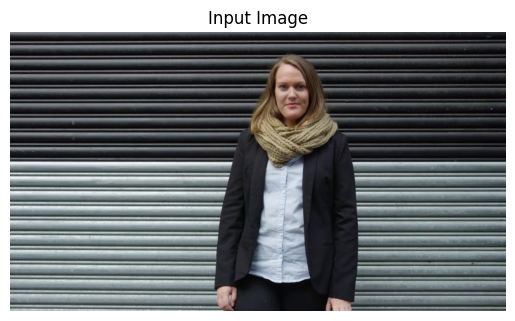

In [26]:
# 이미지 시각화
plt.imshow(image.numpy())  # 값을 [0, 1] 범위로 정규화
plt.title("Input Image")
plt.axis('off')  # 축 숨기기
plt.show()

In [ ]:
# # FGSM 적용
# def apply_fgsm_attack(lpips_fgsm_loss, image):
#     # 원본 이미지에 대한 예측을 사용하여 적대적 이미지 생성
#     initial_prediction = image

#     # 초기 이미지 형태 출력
#     print("Initial prediction shape:", initial_prediction.shape)



#     # y_true와 y_pred의 형태 출력
#     print("y_true shape:", image.shape)  # image가 y_true
#     print("y_pred shape:", initial_prediction.shape)  # initial_prediction이 y_pred

#     adversarial_image, loss_value = lpips_fgsm_loss(image, initial_prediction)  # 원본 이미지와 예측값을 사용
#     return adversarial_image, loss_value

In [31]:
def apply_fgsm_attack(lpips_fgsm_loss, image, epsilon):

    # AlexNet 또는 lpips_fgsm_loss로부터 예측값을 얻어옴
    initial_prediction, loss_value = lpips_fgsm_loss(image, image)  # image와 예측값을 비교

    # 초기 이미지 형태 출력
    print("Initial prediction shape:", initial_prediction.shape)

    # 손실 함수 계산 (원본 이미지와 예측값을 사용)
    print("Loss value before gradient:", loss_value)

    # 그라디언트 테이프 사용 (여기서는 필수)
    with tf.GradientTape() as tape:
        tape.watch(initial_prediction)  # initial_prediction에 대해 그라디언트 계산을 위해 watch
        loss_value = lpips_fgsm_loss(image, initial_prediction)[1]  # 손실 계산

    # 그라디언트 계산
    gradients = tape.gradient(loss_value, initial_prediction)

    # 그라디언트 출력
    print("Gradients:", gradients)

    # FGSM 적대적 공격 적용
    fgsm_layer = FGSMAttackLayer(epsilon)
    adversarial_image = fgsm_layer([image, gradients])

    # 적대적 이미지 및 손실 값 반환
    return adversarial_image, loss_value


In [32]:
# 적대적 이미지 생성
epsilon = 0.01
adversarial_image, loss_value = apply_fgsm_attack(lpips_fgsm_loss, image, epsilon)

Normalized y_true: [[[ 0.04313731  0.07450986  0.10588241]
  [ 0.04313731  0.07450986  0.10588241]
  [ 0.04313731  0.07450986  0.10588241]
  ...
  [-0.62352943 -0.6313726  -0.60784316]
  [-0.62352943 -0.6313726  -0.60784316]
  [-0.62352943 -0.6313726  -0.60784316]]

 [[ 0.02745104  0.05882359  0.09019613]
  [ 0.02745104  0.05882359  0.09019613]
  [ 0.02745104  0.05882359  0.09019613]
  ...
  [-0.6313726  -0.6392157  -0.6156863 ]
  [-0.6313726  -0.6392157  -0.6156863 ]
  [-0.6313726  -0.6392157  -0.6156863 ]]

 [[ 0.00392163  0.03529418  0.06666672]
  [ 0.00392163  0.03529418  0.06666672]
  [ 0.00392163  0.03529418  0.06666672]
  ...
  [-0.6627451  -0.67058825 -0.64705884]
  [-0.6627451  -0.67058825 -0.64705884]
  [-0.6627451  -0.67058825 -0.64705884]]

 ...

 [[ 0.41176474  0.49803925  0.5058824 ]
  [ 0.4039216   0.4901961   0.49803925]
  [ 0.39607847  0.48235297  0.4901961 ]
  ...
  [-0.6392157  -0.56078434 -0.62352943]
  [-0.6392157  -0.56078434 -0.62352943]
  [-0.6392157  -0.5607843

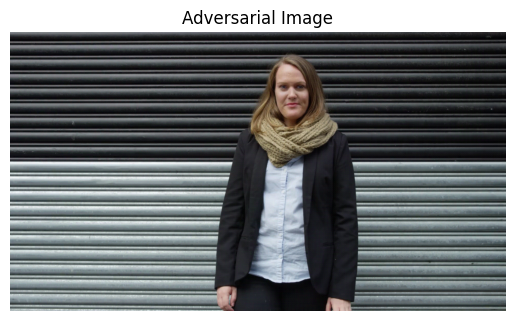

In [33]:
# 적대적 이미지 확인
if adversarial_image.shape == (1, 1080, 1920, 3):
    adversarial_image_numpy = tf.squeeze(adversarial_image).numpy()  # 배치 차원 제거
    adversarial_image_numpy = (adversarial_image_numpy * 255).astype(np.uint8)  # 0-255 범위로 변환

    # 이미지 시각화
    plt.imshow(adversarial_image_numpy)
    plt.title("Adversarial Image")
    plt.axis('off')
    plt.show()
else:
    print("Invalid shape for adversarial image:", adversarial_image.shape)

In [34]:
# 손실 값 확인
print("Loss value:", loss_value.numpy())

Loss value: 0.04663439
